## 03 Decisioning

Copper Day Trader - Daily Directional Trading

### Imports

In [2]:
import numpy as np
import pandas as pd
import ibis
import matplotlib.pyplot as plt
import methods.prep as prep
import methods.vis as vis
import methods.fc as fc
import methods.sim as sim
import importlib

### Load Data

In [7]:
con = ibis.connect("duckdb://")
dev_data = ibis.read_csv('data_decisioning/dev_data.csv')

### Run Forecasting & Enrichment - Development

In [8]:
dev_df = dev_data.to_pandas()
dev_df['DATE'] = pd.to_datetime(dev_df['DATE'])
dev_df = dev_df.sort_values('DATE')

In [9]:
columns = [
    'DATE',
    'COPPER_OPEN_NOMINAL',
    'COPPER_OPEN_NOMINAL_PRED',
    'COPPER_OPEN_NOMINAL_DELTA',
    'COPPER_OPEN_NOMINAL_DELTA_PRED',
    'COPPER_OPEN_NOMINAL_PROPDELTA',
    'COPPER_OPEN_NOMINAL_PROPDELTA_PRED']

dev_df[columns]

,DATE,COPPER_OPEN_NOMINAL,COPPER_OPEN_NOMINAL_PRED,COPPER_OPEN_NOMINAL_DELTA,COPPER_OPEN_NOMINAL_DELTA_PRED,COPPER_OPEN_NOMINAL_PROPDELTA,COPPER_OPEN_NOMINAL_PROPDELTA_PRED
0,2007-01-02,2.8710,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,2.7980,NaN,-0.0730,NaN,-0.025427,NaN
2,2007-01-04,2.6600,NaN,-0.1380,NaN,-0.049321,NaN
3,2007-01-05,2.6110,NaN,-0.0490,NaN,-0.018421,NaN
4,2007-01-08,2.5350,NaN,-0.0760,NaN,-0.029108,NaN
...,...,...,...,...,...,...,...
3292,2019-12-25,2.8250,2.805038,0.0235,0.003538,0.008388,0.001263
3293,2019-12-26,2.8370,2.828721,0.0120,0.003721,0.004248,0.001317
3294,2019-12-27,2.8465,2.843904,0.0095,0.006904,0.003349,0.002433
3295,2019-12-30,2.8245,2.850128,-0.0220,0.003628,-0.007729,0.001274


In [10]:
#Limit to 2008-2019 due to NaNs; drop remaining NaNs if any
dev_df = dev_df[dev_df['DATE'].dt.year >= 2008].dropna()

Create bins for predicted price deltas for the decisioning model to act on

In [13]:
def value_to_bin(x : float,
             breakpoints : list)->int:

    bin = 0
    for breakpoint in breakpoints:
        if x < breakpoint:
            return bin
        bin = bin + 1
    return bin

def values_to_bins(
        df : pd.DataFrame,
        breakpoints : list,
        target_col : str)->pd.DataFrame:
    
    df[target_col + '_BIN'] = df[target_col].apply(lambda x : value_to_bin(x, breakpoints))
    return df

In [11]:
# Calculate breakpoints to divide predicted proportional deltas into buckets according to quantiles
breakpoints = list(dev_df['COPPER_OPEN_NOMINAL_PROPDELTA_PRED'].quantile([x/11.0 for x in range(1,11)]))
breakpoints

[-0.010425720164294371,
 -0.005947391526572783,
 -0.0037235149764711013,
 -0.0021274785085398868,
 -0.0007188654360384516,
 0.0005797337313629594,
 0.0020048888592230775,
 0.003829380022559951,
 0.0061611199439798375,
 0.010490247373252676]

In [14]:
# Add a column with the new bins
dev_df = values_to_bins(dev_df,
    breakpoints,
    'COPPER_OPEN_NOMINAL_PROPDELTA_PRED',)

columns = [
    'DATE',
    'COPPER_OPEN_NOMINAL_PROPDELTA_PRED',
    'COPPER_OPEN_NOMINAL_PROPDELTA_PRED_BIN']

dev_df[columns]

,DATE,COPPER_OPEN_NOMINAL_PROPDELTA_PRED,COPPER_OPEN_NOMINAL_PROPDELTA_PRED_BIN
252,2008-01-02,-0.023190,0
253,2008-01-03,-0.013525,0
254,2008-01-04,-0.000047,5
255,2008-01-07,0.030516,10
256,2008-01-08,0.014530,10
...,...,...,...
3292,2019-12-25,0.001263,6
3293,2019-12-26,0.001317,6
3294,2019-12-27,0.002433,7
3295,2019-12-30,0.001274,6


In [16]:
from time import sleep

importlib.reload(sim)

agent = sim.PortfolioAgent(
    data = dev_df[columns],
    date_col= 'DATE',
    price_delta_pred_bins_col = 'COPPER_OPEN_NOMINAL_PROPDELTA_PRED_BIN',
    price_delta_col = 'COPPER_OPEN_NOMINAL_PROPDELTA_PRED',
    learning_rate = 1, 
    explore_chance = 0.3, #Chance to take a random (legal) action
    rebalance_limit_steps = 2,  # Determine how far asset balances can be changed with each action
    asset_balance_steps = [x/10.0 for x in range(11)],)  # Possible asset balances; 0 is all cash, 1 is all copper futures)

while agent.step(exploring=True, learning=True):
    print('Timestep:  '  + str(agent.current_step))
    print('Date:  ' +  str(agent.data[agent.date_col].iat[agent.current_step]))
    print('Asset Balance:  '  + str(agent.asset_balance_at_open_ind[agent.current_step]*10) + '% Copper Futures (the rest is cash)' )
    print('Portfolio Value:  USD ' + str(agent.portfolio_value[agent.current_step]))


    

Timestep:  1
Date:  2008-01-03 00:00:00
Asset Balance:  20% Copper Futures (the rest is cash)
Portfolio Value:  USD 997294.7235684298
Timestep:  2
Date:  2008-01-04 00:00:00
Asset Balance:  40% Copper Futures (the rest is cash)
Portfolio Value:  USD 997275.3852719143
Timestep:  3
Date:  2008-01-07 00:00:00
Asset Balance:  30% Copper Futures (the rest is cash)
Portfolio Value:  USD 1006404.9029636121
Timestep:  4
Date:  2008-01-08 00:00:00
Asset Balance:  40% Copper Futures (the rest is cash)
Portfolio Value:  USD 1012253.5425407089
Timestep:  5
Date:  2008-01-09 00:00:00
Asset Balance:  50% Copper Futures (the rest is cash)
Portfolio Value:  USD 1004983.6625886508
Timestep:  6
Date:  2008-01-10 00:00:00
Asset Balance:  60% Copper Futures (the rest is cash)
Portfolio Value:  USD 1013256.9087540525
Timestep:  7
Date:  2008-01-11 00:00:00
Asset Balance:  50% Copper Futures (the rest is cash)
Portfolio Value:  USD 1017061.7928270673
Timestep:  8
Date:  2008-01-14 00:00:00
Asset Balance:  5

c:\Users\haits\projects\ea-nasir\methods\vis.py:351: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Date', ylabel='Value'>)

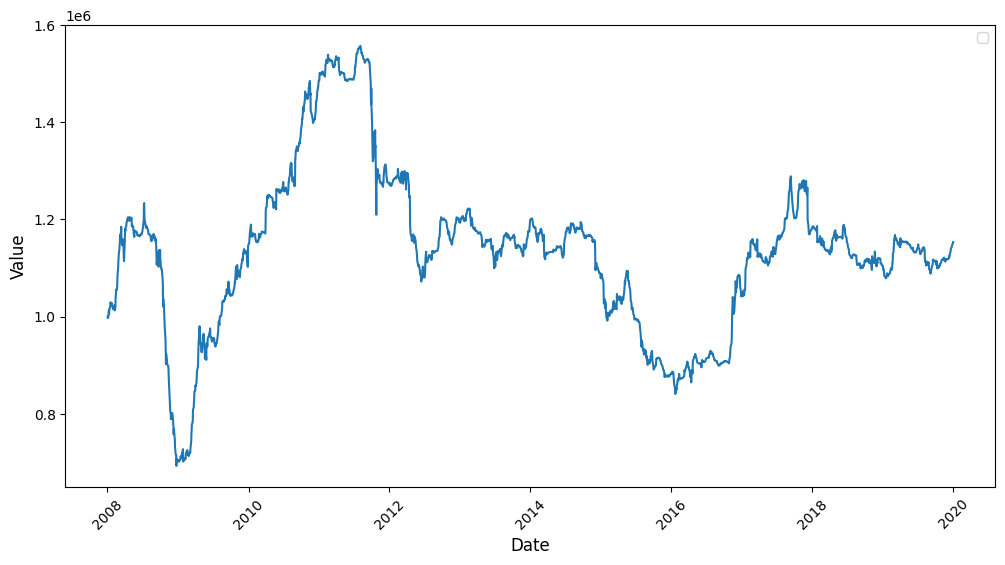

In [22]:
importlib.reload(vis)
vis.plot_time_series(agent.data['DATE'],
                     agent.portfolio_value)

In [23]:
agent.print_model()

State (Current Portfolio Balance, Prediction Bin):  (0, 0) -> 
     Action (New Portfolio Weight)->Weight:  0 -> -0.024303142073325693
     Action (New Portfolio Weight)->Weight:  1 -> -0.04744945984672101
     Action (New Portfolio Weight)->Weight:  2 -> -0.07543827100384885
State (Current Portfolio Balance, Prediction Bin):  (0, 1) -> 
     Action (New Portfolio Weight)->Weight:  0 -> 0.00754088023268271
     Action (New Portfolio Weight)->Weight:  1 -> -0.0352317397484301
     Action (New Portfolio Weight)->Weight:  2 -> -0.012603918085307952
State (Current Portfolio Balance, Prediction Bin):  (0, 2) -> 
     Action (New Portfolio Weight)->Weight:  0 -> -0.0026409191910264176
     Action (New Portfolio Weight)->Weight:  1 -> -0.015991852739108935
     Action (New Portfolio Weight)->Weight:  2 -> 0.012893717923882416
State (Current Portfolio Balance, Prediction Bin):  (0, 3) -> 
     Action (New Portfolio Weight)->Weight:  0 -> -0.0013306676873997975
     Action (New Portfolio Weight

In [15]:
# Takes about a minute
# Run experiment with 500 agents

importlib.reload(sim)
portfolio_values = []
for i in range(500):
    agent = sim.PortfolioAgent(
        data = dev_df[columns],
        date_col= 'DATE',
        price_delta_pred_bins_col = 'COPPER_OPEN_NOMINAL_PROPDELTA_PRED_BIN',
        price_delta_col = 'COPPER_OPEN_NOMINAL_PROPDELTA_PRED',
        learning_rate = 1, 
        explore_chance = 0.3, #Chance to take a random (legal) action
        rebalance_limit_steps = 2,  # Determine how far asset balances can be changed with each action
        asset_balance_steps = [x/10.0 for x in range(11)],)  # Possible asset balances; 0 is all cash, 1 is all copper futures)

    while True:
        if not agent.step(exploring=True, learning=True):
            break

    print('Agent ' + str(i) + ' complete')
    portfolio_values.append(agent.portfolio_value[agent.current_step])


Agent 0 complete
Agent 1 complete
Agent 2 complete
Agent 3 complete
Agent 4 complete
Agent 5 complete
Agent 6 complete
Agent 7 complete
Agent 8 complete
Agent 9 complete
Agent 10 complete
Agent 11 complete
Agent 12 complete
Agent 13 complete
Agent 14 complete
Agent 15 complete
Agent 16 complete
Agent 17 complete
Agent 18 complete
Agent 19 complete
Agent 20 complete
Agent 21 complete
Agent 22 complete
Agent 23 complete
Agent 24 complete
Agent 25 complete
Agent 26 complete
Agent 27 complete
Agent 28 complete
Agent 29 complete
Agent 30 complete
Agent 31 complete
Agent 32 complete
Agent 33 complete
Agent 34 complete
Agent 35 complete
Agent 36 complete
Agent 37 complete
Agent 38 complete
Agent 39 complete
Agent 40 complete
Agent 41 complete
Agent 42 complete
Agent 43 complete
Agent 44 complete
Agent 45 complete
Agent 46 complete
Agent 47 complete
Agent 48 complete
Agent 49 complete
Agent 50 complete
Agent 51 complete
Agent 52 complete
Agent 53 complete
Agent 54 complete
Agent 55 complete
Ag

In [ ]:
np.median(portfolio_values)

In [ ]:
np.mean(portfolio_values)